In [1]:
%load_ext autoreload
%autoreload 2

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyForwardFolding as pyFF
import scipy.stats

In [2]:
data = pd.read_parquet("../../NNMFit_testdata/src/NNMFit_testdata/data/datasets/Toise_ToyTracks/dataframe.parquet")

input_variables = {
    "true_energy": jnp.asarray(data.true_e),
    "log10_reco_energy": jnp.log10(jnp.asarray(data.reco_e)),
    "cos_reco_zenith": jnp.cos(jnp.asarray(data.reco_zenith)),
    "baseline_weight": jnp.asarray(data.fluxless_weight),
    "conv_weight": jnp.asarray(data.weight_honda2006),
    "e_scaling": jnp.asarray(data.e_scaling),
    "e_smearing": jnp.asarray(data.e_smearing),
    "median_energy": 2500.,
}

input_variables_2 = {
    "muon_weight": jnp.ones_like(input_variables["true_energy"]),
    "log10_reco_energy": jnp.log10(jnp.asarray(data.reco_e)),
    "cos_reco_zenith": jnp.cos(jnp.asarray(data.reco_zenith)),
    "e_scaling": jnp.asarray(data.e_scaling),
    "e_smearing": jnp.asarray(data.e_smearing),
}

dataset = {"dataset1": input_variables, "dataset2": input_variables_2}


In [3]:
ana = pyFF.config.analysis_from_config("test.yaml")


In [4]:
ana

# Analysis Configuration
**1 expectations configured**

## Summary
| Aspect | Details |
|--------|---------|
| Required variables | `cos_reco_zenith, e_scaling, e_smearing, log10_reco_energy, median_energy, true_energy` |
| Exposed parameters | `astro_index, astro_norm, atmo_norm, delta_gamma, escale, esmear, muon_norm` |

  - **Expectation:** `det1`
    - Datasets: `['dataset1', 'dataset2']`

    - Models (2):
    1. **model** (2 components) - Uses datasets: `dataset1`
      - **Model:** model
        - Components (2):
        - **astro** (weight: baseline_weight)
        - **atmo** (weight: conv_weight)
    2. **mock_muon_model** (1 components) - Uses datasets: `dataset2`
      - **Model:** mock_muon_model
        - Components (1):
        - **muons** (weight: muon_weight)

    - Binning:
      - Type: `RectangularBinning`
      - Variables: `['log10_reco_energy', 'cos_reco_zenith']`
      - Dimensions: `(30, 24)` (720 bins)

    - Required variables: 6
    - Exposed parameters: 7
    - Lifetime: `1.0`


In [5]:
ana.expectations["det1"]

## Expectation: `det1`
**Datasets:** `['dataset1', 'dataset2']`

**Models (2):**
1. **model** (2 components) - Uses datasets: `dataset1`
  - **Model:** model
    - Components (2):
    - **astro** (weight: baseline_weight)
    - **atmo** (weight: conv_weight)
2. **mock_muon_model** (1 components) - Uses datasets: `dataset2`
  - **Model:** mock_muon_model
    - Components (1):
    - **muons** (weight: muon_weight)

**Binning:**
  - Type: `RectangularBinning`
  - Variables: `['log10_reco_energy', 'cos_reco_zenith']`
  - Dimensions: `(30, 24)` (720 bins)

**Configuration Summary:**
| Aspect | Count/Details |
|--------|---------------|
| Required variables | 6 |
| Exposed parameters | 7 |
| Lifetime | `1.0` |

In [6]:
ana.expectations["det1"].models[0]

### Model: model

**Required variables:** `['e_scaling', 'e_smearing', 'median_energy', 'true_energy']`

**Exposed parameters:** `['astro_index', 'astro_norm', 'atmo_norm', 'delta_gamma', 'escale', 'esmear']`
**Components (2):**
- **astro** (weight: baseline_weight)
  - **ModelComponent:** astro
    - Factors (3):
      - **PowerLawFlux** (`powerlaw`)
        - Parameters:
          - `flux_norm` → `astro_norm`
          - `spectral_index` → `astro_index`
        - Required variables:
          - `true_energy`
      - **SnowstormGauss** (`snowstorm_escale`)
        - Parameters:
          - `scale` → `escale`
        - Required variables:
          - `e_scaling`
      - **SnowstormGauss** (`snowstorm_esmear`)
        - Parameters:
          - `scale` → `esmear`
        - Required variables:
          - `e_smearing`

    - Required variables: `['e_scaling', 'e_smearing', 'true_energy']`
    - Exposed parameters: `['astro_index', 'astro_norm', 'escale', 'esmear']`
- **atmo** (weight: conv_weight)
  - **ModelComponent:** atmo
    - Factors (4):
      - **FluxNorm** (`atmo_norm`)
        - Parameters:
          - `flux_norm` → `atmo_norm`
      - **DeltaGamma** (`delta_gamma`)
        - Parameters:
          - `delta_gamma` → `delta_gamma`
        - Required variables:
          - `true_energy`
          - `median_energy`
      - **SnowstormGauss** (`snowstorm_escale`)
        - Parameters:
          - `scale` → `escale`
        - Required variables:
          - `e_scaling`
      - **SnowstormGauss** (`snowstorm_esmear`)
        - Parameters:
          - `scale` → `esmear`
        - Required variables:
          - `e_smearing`

    - Required variables: `['e_scaling', 'e_smearing', 'median_energy', 'true_energy']`
    - Exposed parameters: `['atmo_norm', 'delta_gamma', 'escale', 'esmear']`

In [7]:
ana.expectations["det1"].models[0].components[0]

#### ModelComponent: astro
**Factors (3):**
  - **PowerLawFlux** (`powerlaw`)
    - Parameters:
      - `flux_norm` → `astro_norm`
      - `spectral_index` → `astro_index`
    - Required variables:
      - `true_energy`
  - **SnowstormGauss** (`snowstorm_escale`)
    - Parameters:
      - `scale` → `escale`
    - Required variables:
      - `e_scaling`
  - **SnowstormGauss** (`snowstorm_esmear`)
    - Parameters:
      - `scale` → `esmear`
    - Required variables:
      - `e_smearing`

**Required variables:** `['e_scaling', 'e_smearing', 'true_energy']`

**Exposed parameters:** `['astro_index', 'astro_norm', 'escale', 'esmear']`

In [8]:
ana = pyFF.config.analysis_from_config("test.yaml")

prior_bounds = {
    "astro_norm": (0.0, 3),
    "astro_index": (1.0, 4.0),
    "atmo_norm": (0.0, np.inf),
    "escale": (0.9, 1.1),
    "esmear": (0.9, 1.1),
    "delta_gamma": (-1.0, 1.0),
    "muon_norm": (0.0, np.inf)
}

prior_seeds = {
    "astro_norm": 1.0,
    "astro_index": 2.37,
    "atmo_norm": 1.0,
    "escale": 1.0,
    "esmear": 1.0,
    "delta_gamma": 0.0,
    "muon_norm": 0.0,
}

priors = [
    pyFF.likelihood.UniformPrior(prior_seeds, prior_bounds)
]


lik_p = pyFF.likelihood.PoissonLikelihood(ana, priors)
lik_s = pyFF.likelihood.SAYLikelihood(ana, priors)


In [9]:
lik_p.get_bounds()

{'astro_norm': (0.0, 3),
 'astro_index': (1.0, 4.0),
 'atmo_norm': (0.0, inf),
 'escale': (0.9, 1.1),
 'esmear': (0.9, 1.1),
 'delta_gamma': (-1.0, 1.0),
 'muon_norm': (0.0, inf)}

In [10]:
model_parameters = {
    "astro_norm": 1.0,
    "astro_index": 2.37,
    "atmo_norm": 1.0,
    "escale": 1.0,
    "esmear": 1.0,
    "delta_gamma": 0.0,
    "muon_norm": 0.0,
}


[]

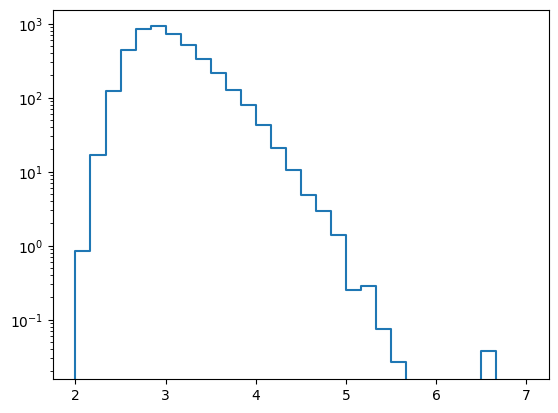

In [11]:
be = ana.expectations["det1"]
pred = ana.evaluate(dataset, model_parameters)[0]
hsum = pred["det1"].sum(axis=1)
plt.step(be.binning.bin_edges[0], jnp.append(hsum, hsum[-1]))
plt.semilogy()



In [12]:
hist, hist_ssq = ana.evaluate(dataset, model_parameters)

pgen = pyFF.statistics.PseudoExpGenerator(ana, dataset, model_parameters)
pexp = next(pgen.generate(1))
obs = hist

In [13]:
def eval_for_par(par_val, par_dict, llh_f):
    par_dict["astro_norm"]= par_val
    lh = llh_f(obs, dataset, par_dict)
    return lh


val_grad = jax.jit(jax.value_and_grad(eval_for_par, 0), static_argnums=(2,))


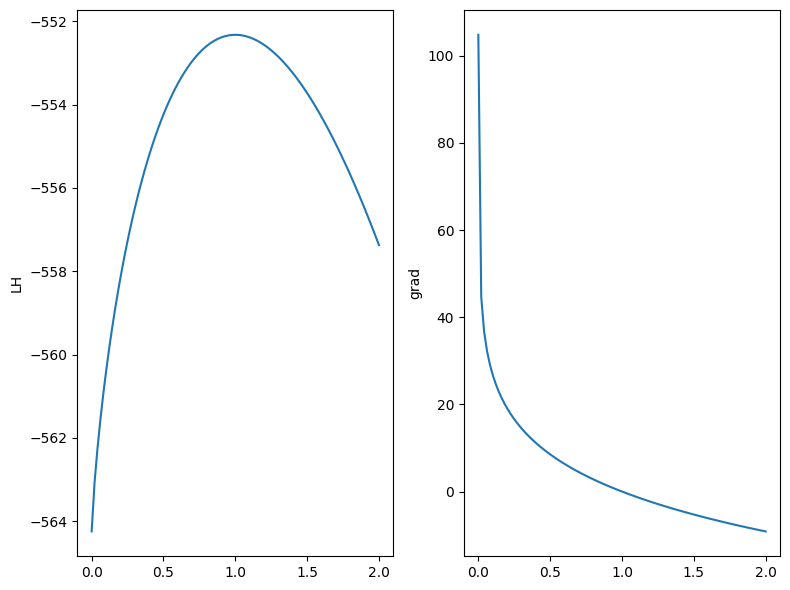

In [14]:
scan_vals = jnp.linspace(0, 2, 100)
lhs, grads = jax.vmap(val_grad, in_axes=(0, None, None))(scan_vals, model_parameters, lik_p.llh)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
ax1.plot(scan_vals, lhs)
ax1.set_ylabel("LH")
ax2.plot(scan_vals, grads)
ax2.set_ylabel("grad")
plt.tight_layout()

In [15]:
wrapped_lh = pyFF.minimizer.WrappedLLH(lik_p, obs, dataset, {})



In [16]:
dest_args = pyFF.minimizer.destructure_args(model_parameters, ana.exposed_parameters, {})
hess_func = jax.jit(jax.hessian(wrapped_lh))
hessian = hess_func(jnp.asarray(dest_args))
fisher = jnp.linalg.inv(hessian)
#sns.heatmap(fisher, cmap="viridis", xticklabels=ana.exposed_parameters, yticklabels=ana.exposed_parameters)

In [24]:
fmin_and_grad = jax.jit(jax.value_and_grad(wrapped_lh))

In [29]:
mini = pyFF.minimizer.ScipyMinimizer(lik_p)

mini.minimize(obs, dataset, fixed_pars={"astro_norm": 0.0})


(  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
   success: True
    status: 0
       fun: 555.1632493599856
         x: [ 2.370e+00  2.901e-01 -5.818e-02  9.973e-01  9.975e-01
              3.393e-02]
       nit: 32
       jac: [ 0.000e+00  4.871e-04  1.575e-04  1.042e-03  1.239e-03
              1.100e-02]
      nfev: 37
      njev: 37
  hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>,
 {'astro_index': np.float64(2.37),
  'astro_norm': 0.0,
  'atmo_norm': np.float64(0.29008826952475436),
  'delta_gamma': np.float64(-0.05817562107100916),
  'escale': np.float64(0.9972685407561482),
  'esmear': np.float64(0.9974751580500969),
  'muon_norm': np.float64(0.03392812443036212)},
 555.1632493599856)

In [56]:
h0 = pyFF.statistics.Hypothesis(
    "Null",
    likelihood=lik_p,
    fixed_pars={"astro_norm": 0.0},
)

h1 = pyFF.statistics.Hypothesis(
    "Alternative",
    likelihood=lik_p,
    fixed_pars=None,
)


test = pyFF.statistics.HypothesisTest(h0, h1, dataset)


In [17]:
test = pyFF.statistics.HypothesisTest.from_likelihood(lik_p, dataset, {"astro_norm": 0.0})

In [21]:
obs = test.h0.asimov_experiment(dataset)
scan_points, ts_val = test.scan(obs, 20)

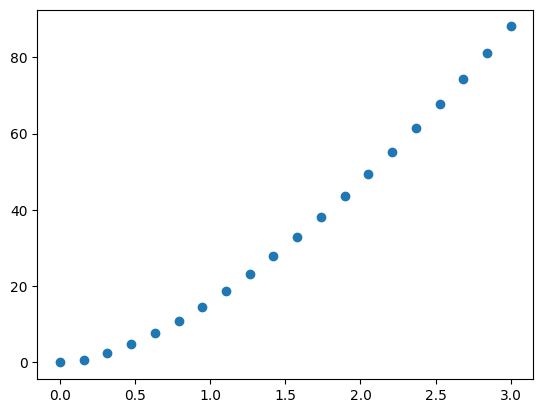

In [22]:
plt.scatter(scan_points, ts_val)

In [ ]:
null_ts_vals = test.null_dist(500)


In [ ]:
null_dist, alt_dist, alt_param_value = test.discovery_potential(400, 30, 2, 0.05, 10, null_dist=null_ts_vals)

called with x = 0.0
called with x = 10.0
called with x = 0.344140204692762
called with x = 1.8427894047607447
called with x = 0.8332721984934197
called with x = 0.9208742761949203
called with x = 1.3818318404778325
called with x = 1.001116665211734
called with x = 0.956856546380029


In [ ]:
sigma_level = 2.0

# Calc median of alt dist
alt_median = pyFF.backend.backend.median(alt_dist)   

# Calc p-value for sigma level
p_value = 1 - pyFF.backend.backend.norm_sf(sigma_level)

# Calculate the threshold for discovery
threshold = pyFF.backend.backend.quantile(null_dist, p_value)

In [ ]:
alt_param_value_asimov = test.discovery_potential_asimov(sigma_level=2, xtol=0.02, maxiter=25)

Parameter bounds: (0.0, 10.0)


In [ ]:
alt_param_value_asimov

0.8169555000114688

In [ ]:
alt_param_value, alt_param_value_asimov

(0.956856546380029, 0.8248826977840399)

Text(0.5, 1.0, 'Test Statistic Distributions')

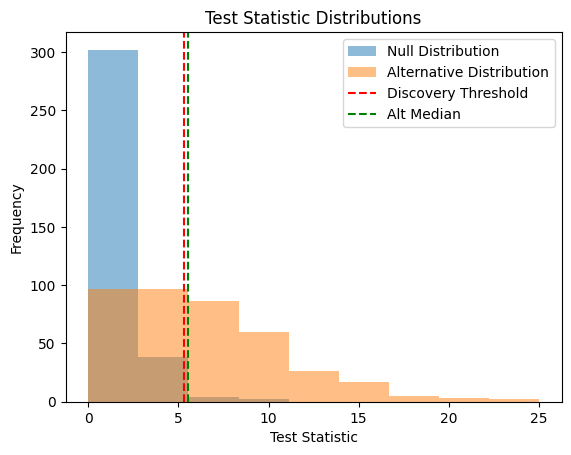

In [ ]:
bins = np.linspace(0, 25, 10)
plt.hist(null_dist, bins=bins, alpha=0.5, label='Null Distribution')
plt.hist(alt_dist, bins=bins, alpha=0.5, label='Alternative Distribution')
plt.axvline(threshold, color='red', linestyle='--', label='Discovery Threshold')
plt.axvline(alt_median, color='green', linestyle='--', label='Alt Median')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.legend()
plt.title('Test Statistic Distributions')


In [75]:
null_asimov = h0.asimov_experiment()
alt_asimov = h1.asimov_experiment()

ts_asimov_null = test.test(null_asimov)
ts_asimov_alt = test.test(alt_asimov)


In [49]:
import scipy.optimize

astro_scan = np.linspace(0, 3, 100)

scan_res = []

for astro in astro_scan:

    bounds = scipy.optimize.Bounds(
        [astro,      1.0, 0.9, 0.9, 0,      -1],
        [astro,      4.0, 1.1, 1.1, np.inf,  1]
    )

    res = scipy.optimize.minimize(fmin_and_grad, [1.001, 2.37, 1., 1., 1., 0.01], bounds=bounds, jac=True, method="L-BFGS-B", tol=10)
    scan_res.append(res.fun)

bounds = scipy.optimize.Bounds(
        [0,      1.0, 0.9, 0.9, 0,      -1],
        [np.inf,      4.0, 1.1, 1.1, np.inf,  1]
    )

free_fit = scipy.optimize.minimize(fmin_and_grad, [1.001, 2.37, 1., 1., 1., 0.01], bounds=bounds, jac=True, method="L-BFGS-B", tol=10)

Text(0, 0.5, 'Test Statistic')

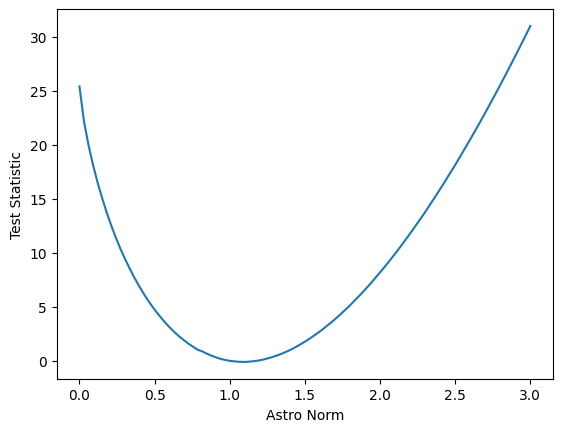

In [52]:
plt.plot(astro_scan, 2*(np.asarray(scan_res) - free_fit.fun))
plt.xlabel("Astro Norm")
plt.ylabel("Test Statistic")

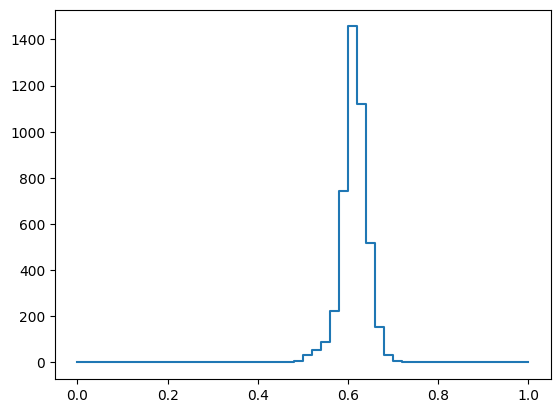

In [75]:
nn_in = jnp.vstack([
            input_variables["log10_reco_energy"],
            input_variables["cos_reco_zenith"],]).T
summary_stat = state.apply_fn({"params": state.params}, nn_in)[:, 0]
input_variables["summary_stat"] = summary_stat
dataset = {"det1": input_variables}
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
hsum = hist["det1"]
plt.step(be.binning.bin_edges[0], jnp.append(hsum, hsum[-1]))

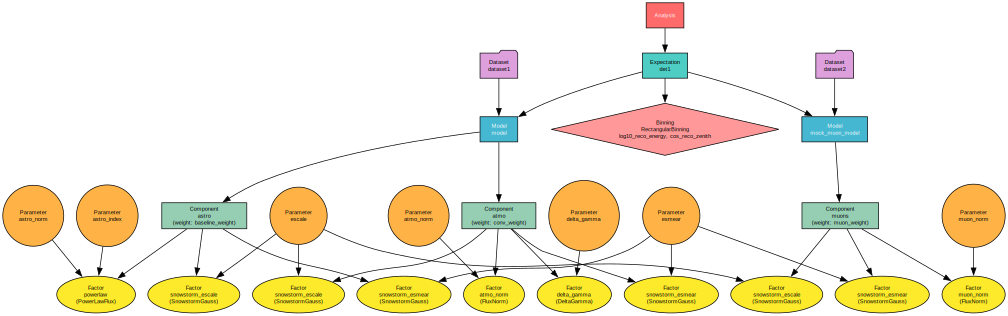

In [20]:
g = ana.render_graph(
        figsize=(14, 10),
        node_size=2000,
        font_size=8,
        layout="dot",
        show_datasets=True,
        show_parameters=True,
        engine="graphviz",
    )
g
